In [1]:
import os
import ee
import numpy as np
import rsfuncs as rs
import pandas as pd
import geopandas as gp

import matplotlib.pyplot as plt

from tqdm import tqdm
from shapely.geometry import Polygon

ee.Initialize()

In [2]:
# Helpers 

def dict2arr(data_dict, var_name):
    '''converts ee dictionary output from .getInfo() to a numpy array. Wraps array_from_df'''
    
    data = data_dict[var_name]
    lats = data_dict['latitude']
    lons = data_dict['longitude']

    df = pd.DataFrame([data,lats,lons]).T
    df.columns = [var_name, "latitude", 'longitude']
    arr = rs.array_from_df(df, var_name)
    
    return arr

In [3]:
# Get some info about the image collection 
imcol = ee.ImageCollection("users/aguzman/Kaweah_disalexi")
imList = imcol.toList(imcol.size())
months = int(imList.size().getInfo())
img1 = ee.Image(imList.get(0));
latlon = ee.Image.pixelLonLat().addBands(img1)

In [4]:
# Read the shapefile, split it
gdf = gp.read_file("../shape/kb_rpj.shp").simplify(0.09)
dx,dy = 0.25, 0.25
area = rs.gdf_to_ee_poly(gdf)

print("Splitting Geometry")
polys = rs.gen_polys(area, dx = dx, dy = dy)
polydict = polys.getInfo()

# Ensure each poly is a single geometry (should already be the case, but make sure)
valid_polys = []

for i in tqdm(polydict['features'][:]):
    aoi = ee.Geometry.Polygon(i['geometry']['coordinates']).intersection(area)
    pols = aoi.getInfo()['coordinates']
    if len(pols) == 0:
        continue
    if len(pols) == 1:
        valid_polys.append(ee.Geometry.Polygon(pols))
    if len(pols) > 1:
        for i in pols:
            valid_polys.append(ee.Geometry.Polygon(i))

# Make a dict with the poly IDs
polycoords = {}

for idx,poly in enumerate(valid_polys):
    polycoords[idx] = poly['coordinates']

  0%|          | 0/3 [00:00<?, ?it/s]

Splitting Geometry


100%|██████████| 7/7 [00:00<00:00,  8.01it/s]


/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


../rasters/openet/time_0 disal_p0_t0.tif ../rasters/openet/time_0/disal_p0_t0.tif


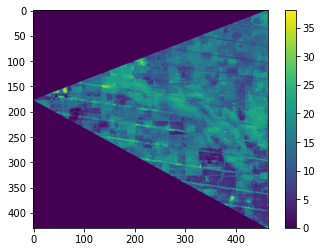

/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


../rasters/openet/time_0 disal_p1_t0.tif ../rasters/openet/time_0/disal_p1_t0.tif


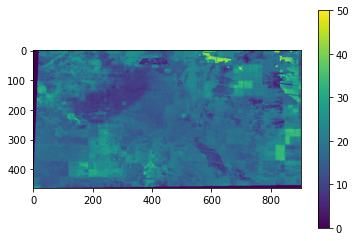

/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


../rasters/openet/time_0 disal_p2_t0.tif ../rasters/openet/time_0/disal_p2_t0.tif


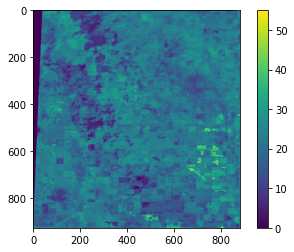

/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


../rasters/openet/time_0 disal_p3_t0.tif ../rasters/openet/time_0/disal_p3_t0.tif


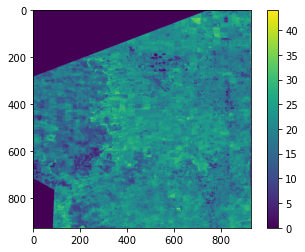

/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


../rasters/openet/time_0 disal_p4_t0.tif ../rasters/openet/time_0/disal_p4_t0.tif


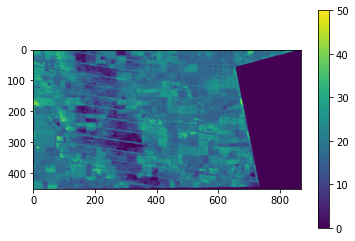

/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


../rasters/openet/time_0 disal_p5_t0.tif ../rasters/openet/time_0/disal_p5_t0.tif


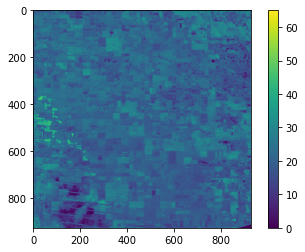

/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


../rasters/openet/time_0 disal_p6_t0.tif ../rasters/openet/time_0/disal_p6_t0.tif


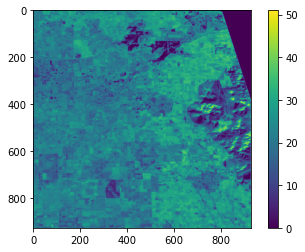

In [5]:
# to test 
num_images = 1 # months.copy()

model_name = 'disal'

# Loop through polygons 
for polyidx, poly in polycoords.items():
    
    # get aoi as gdf
    aoi = ee.Geometry.Polygon(poly)
    coords = aoi.getInfo()['coordinates'][0]
    lons = []
    lats = []

    for ll in coords:
        lon,lat = ll
        lats.append(lat)
        lons.append(lon)
        
    polygon_geom = Polygon(zip(lons, lats))
    crs = {'init':'epsg:4326'}
    aoi_gdf = gp.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])   
    aoi_gdf.plot()

    # Loop through time slices
    for im_idx in range(0,1):
        imdat = ee.Image.pixelLonLat().addBands(imList.get(im_idx)).reduceRegion(reducer=ee.Reducer.toList(),geometry=aoi,scale=30)
        et_im = dict2arr(imdat.getInfo(), 'et')
        
        # setup time slice dir (hope this is good idea)
        timedir = "../rasters/openet/time_{}".format(im_idx)
        if not os.path.exists(timedir):
            os.mkdir(timedir)
        
        resultfn = "{}_p{}_t{}.tif".format(model_name,str(polyidx), str(im_idx))
        outfn = os.path.join(timedir,resultfn)
        
        # write out
#         rs.write_raster(et_im, aoi_gdf,outfn)

        print(timedir, resultfn, outfn)
        plt.imshow(et_im)
        plt.colorbar()
        plt.show()
        

    
    